##### Projeto desenvolvido no curso Data Science em Produção da Comunidade DS. 
##### O objetivo é obter a previsão do valor das vendas de cada loja da rede Rossmann nas próximas 6 semanas para que o CFO possa alocar da melhor maneira o orçamento para reformar cada uma das lojas.
##### Os dados utilizados para esse projeto estão disponíveis na plataforma Kaggle.

In [1]:
import math
import pickle
import random 
import datetime
import inflection
import numpy               as np
import pandas              as pd
import seaborn             as sns
import xgboost             as xgb
import plotly.express      as px
import matplotlib.gridspec as gridspec

from scipy                import stats  as ss
from boruta               import BorutaPy
from matplotlib           import pyplot as plt
from IPython.display      import Image
from IPython.core.display import HTML

from tabulate import tabulate

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder 

# 0.0 IMPORTS

### 0.1 Helper functions

In [2]:
def cross_validation(x_training, kfold, model_name, model, verbose = False):
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
            
        # Start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)
        
        # Filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        
        # Training and validation dataset
        # Training
        xtraining = training.drop(['date', 'sales'], axis = 1)
        ytraining = training['sales']
        
        # Validation
        xvalidation = validation.drop(['date', 'sales'], axis = 1)
        yvalidation = validation['sales']
        
        # Model
        m = model.fit(xtraining, ytraining)
        
        # Prediction
        yhat = m.predict(xvalidation)
        
        # Performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        # Store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index = [0])                 

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat)/y)

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat)/y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index = [0])

def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min( kcorr-1, rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML( '<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings

<function __main__.jupyter_settings()>

### 0.2. Loading data

In [4]:
df_sales_raw = pd.read_csv('/home/marcela-pretto-amorim/ds/repos/curso-ds-producao/data/train.csv', low_memory = False) # low_memory faz com que a função leia todo arquivo de uma vez só 
df_store_raw = pd.read_csv('/home/marcela-pretto-amorim/ds/repos/curso-ds-producao/data/store.csv', low_memory = False)

# merge
# o primeiro df é a referência, o how é como serão unidos e on é a coluna que há semelhante nos dois dfs que serão unidos
df_raw = pd.merge( df_sales_raw, df_store_raw, how = 'left', on = 'Store') 

In [10]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
852700,511,2,2013-05-28,5267,786,1,1,0,0,a,a,2060.0,9.0,2009.0,0,NaN,NaN,NaN


# 1.0 DESCRIÇÃO DOS DADOS

In [11]:
df1 = df_raw.copy()

### 1.1 Rename Columns

In [12]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday',
            'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x) # função para reescrever todas as letras em minusculo

cols_new = list(map(snakecase, cols_old)) # aplica a função desejada

# Rename
df1.columns = cols_new

### 1.2 Data dimensions

In [13]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


### 1.3 Data types

In [14]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4 Check NA

In [15]:
df1.isna().sum() #quantos naS tem por coluna

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5 Fillout NA

In [16]:
# competition_distance = distancia entre a loja e uma concorrente  
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

# competition_open_since_month = mes em que o competidor mais proximo foi aberto   
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

# competition_open_since_year = ano em que o competidor mais proximo foi aberto   
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

# promo2_since_week = se a loja esta com programa de promocao continuada; 0 não está com promocao e 1 indica que está              
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

# promo2_since_year = se a loja esta com programa de promocao continuada; 0 não está com promocao e 1 indica que está       
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

# promo_interval = quando começou a promocao   
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis = 1)

In [17]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [18]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
1008768,479,2,2013-01-08,14508,1581,1,1,0,0,a,a,320.0,12.0,2005.0,1,9.0,2011.0,"Feb,May,Aug,Nov",Jan,0


### 1.6 Change Data Types

In [19]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

### 1.7 Descriptive Statistics

In [21]:
# Separação em variáveis numéricas e categóricas
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

#### 1.7.1 Numerical Attributes

In [22]:
# Central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


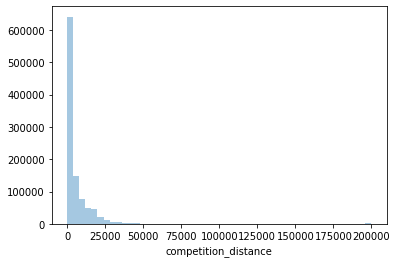

In [23]:
sns.distplot(df1['competition_distance'], kde = False)

#### 1.7.2 Categorical Atributes

In [24]:
# Níveis das variáveis categóricas
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

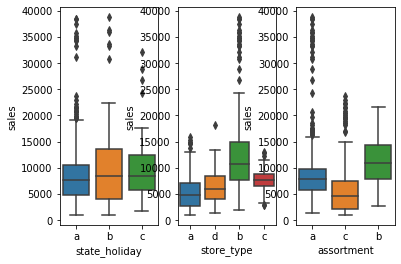

In [25]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1)

# 2.0 FEATURE ENGINEERING

In [26]:
df2 = df1.copy()

### 2.1 Mapa mental de Hipóteses

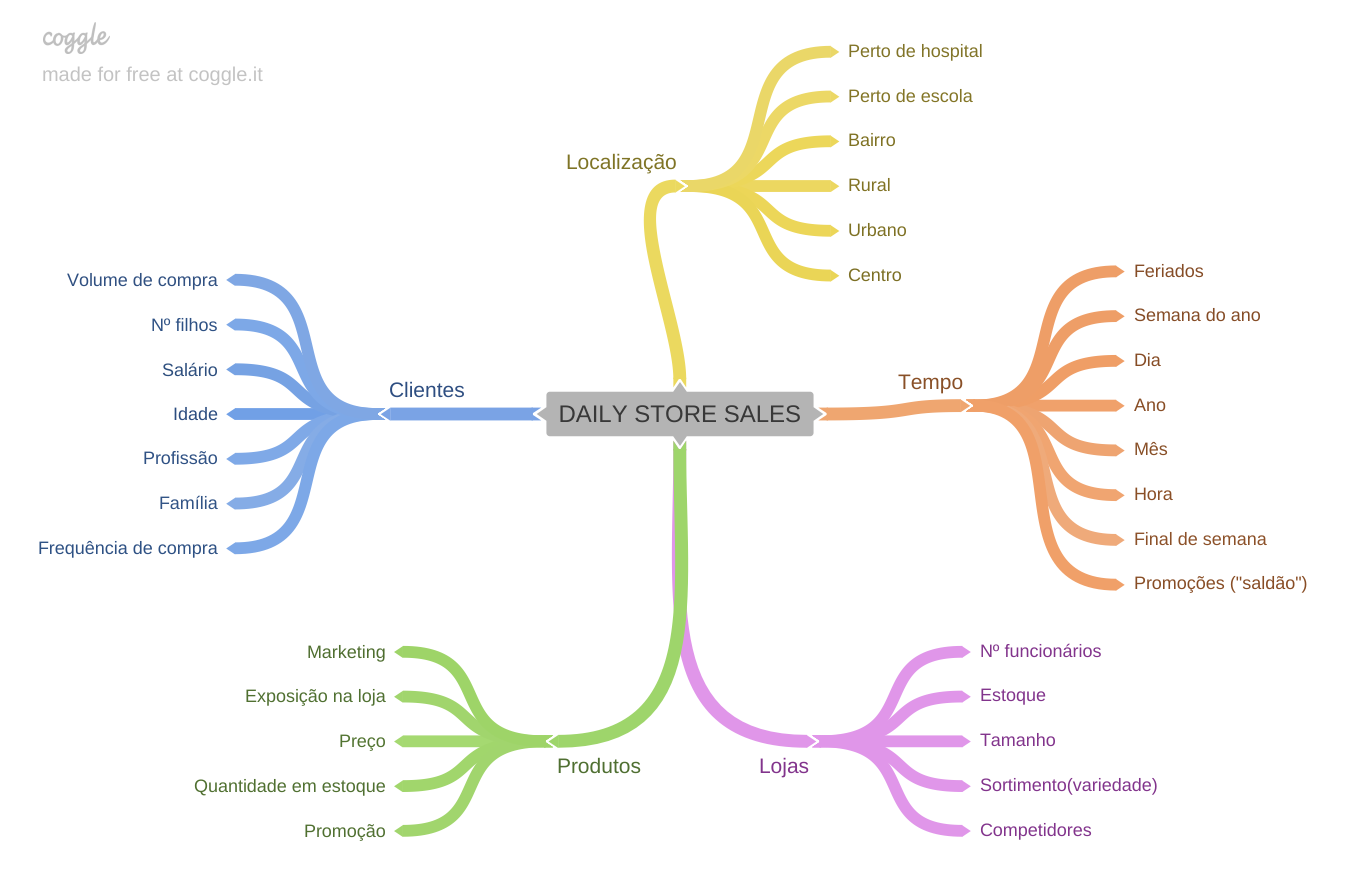

In [30]:
Image('/home/marcela-pretto-amorim/ds/repos/curso-ds-producao/img/MindMapHypothesis_.png')

### 2.2 Criação das Hipóteses

#### 2.1.1 Hipóteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais

**2.** Lojas com maior capacidade de estoque deveriam vender mais

**3.** Lojas com maior porte deveriam vender mais

**4.** Lojas com maior sortimentos deveriam vender mais

**5.** Lojas com competidores mais próximos deveriam vender menos

**6.** Lojas com competidores à mais tempo deveriam vendem mais

#### 2.1.2 Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais

**2.** Lojas com maior exposição de produto deveriam vender mais

**3.** Lojas com produtos com preço menor deveriam vender mais

**4.** Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais

**6.** Lojas com mais dias de promoção deveriam vender mais

**7.** Lojas com mais promoções consecutivas deveriam vender mais

#### 2.1.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais

**2.** Lojas deveriam vender mais ao longo dos anos

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês

**5.** Lojas deveriam vender menos aos finais de semana

**6.** Lojas deveriam vender menos durante os feriados escolares

### 2.3 Lista final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais

**2.** Lojas com competidores mais próximos deveriam vender menos

**3.** Lojas com competidores à mais tempo deveriam vendem mais

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais

**5.** Lojas com mais dias de promoção deveriam vender mais

**6.** Lojas com mais promoções consecutivas deveriam vender mais

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais

**8.** Lojas deveriam vender mais ao longo dos anos

**9**. Lojas deveriam vender mais no segundo semestre do ano

**10**. Lojas deveriam vender mais depois do dia 10 de cada mês

**11**. Lojas deveriam vender menos aos finais de semana

**12**. Lojas deveriam vender menos durante os feriados escolares

### 2.4 Feature Engineering

In [32]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [33]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 FILTRAGEM DAS VARIÁVEIS

In [34]:
df3 = df2.copy()

### 3.1 Filtragem das linhas

In [35]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

### 3.2 Seleção das colunas

In [36]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis =1)

# 4.0 ANÁLISE EXPLORATÓRIA DOS DADOS

In [37]:
df4 = df3.copy()

### 4.1 Análise Univariada

#### 4.1.1 Response Variable

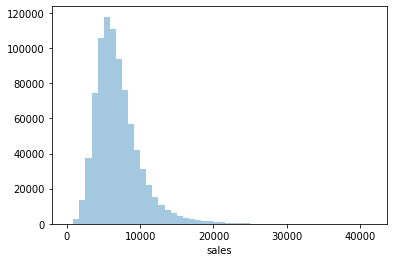

In [39]:
sns.distplot(df4['sales'], kde = False)

#### 4.1.2 Numerical Variable

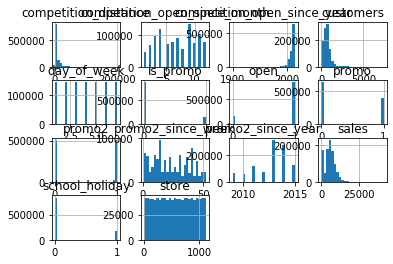

In [40]:
num_attributes.hist(bins = 25);

#### 4.1.3 Categorical Variable

In [41]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

AttributeError: 'Line2D' object has no property 'fill'

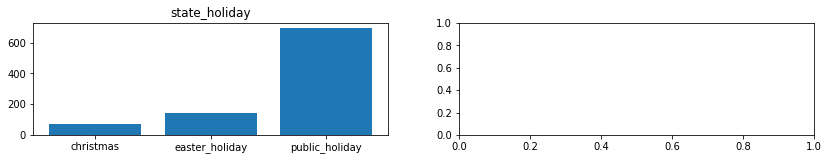

In [42]:
plt.figure(figsize = (14, 7))
# state_holiday
plt.subplot(3, 2, 1)
# Dados
a = df4[df4['state_holiday'] != 'regular_day']
categories = a['state_holiday']

# Contagem das categorias
unique_categories, counts = np.unique(categories, return_counts=True)

# Criação do gráfico de barras
plt.bar(unique_categories, counts)
plt.title('state_holiday')

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', fill = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', fill = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', fill = True)

# store_type
plt.subplot(3, 2, 3)
# Dados
stores = df4['store_type']

# Contagem das categorias
unique_stores, counts = np.unique(stores, return_counts=True)

# Criação do gráfico de barras
plt.bar(unique_stores, counts)
plt.title('store_type')

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill = True)

# assortment
plt.subplot(3, 2, 5)
# Dados
assortments = df4['assortment']

# Contagem das categorias
unique_assortments, counts = np.unique(assortments, return_counts=True)

# Criação do gráfico de barras
plt.bar(unique_assortments, counts)
plt.title('assortments')

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill = True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill = True)


### 4.2 Análise Bivariada

Validar as hipóteses finais

#### **H1.** Lojas com maior sortimentos deveriam vender mais

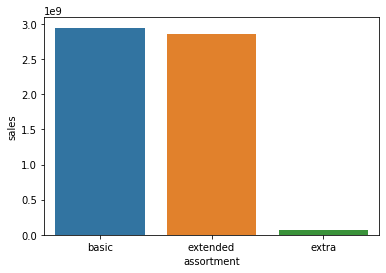

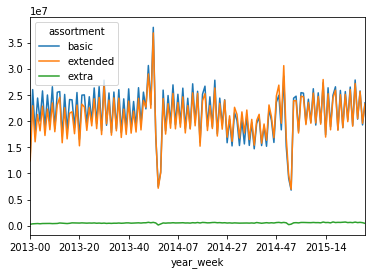

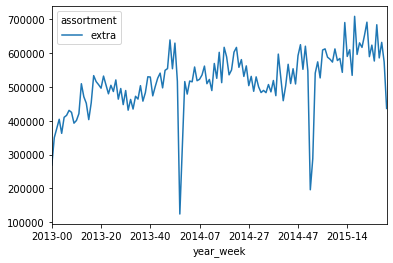

In [43]:
# Comportamento das vendas no total por tipo de sorteamento
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1);

# Verificar o comportamento das vendas ao longo do tempo
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot();

# Conferir o comportamento somente do assortment = extra
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

***Conclusão:*** lojas com **SORTIMENTO** maior vendem **MENOS**.
H1 é hipótese falsa.

#### **H2.** Lojas com competidores mais próximos deveriam vender menos

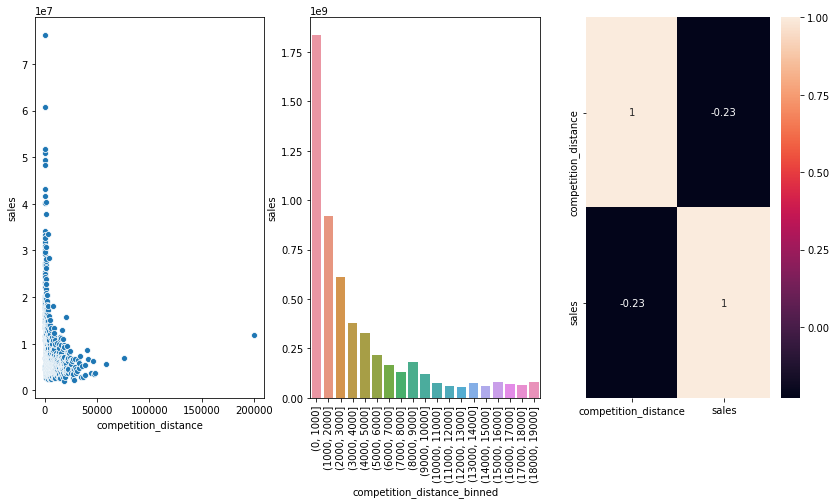

In [44]:
plt.figure(figsize=(14, 7))
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1);

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000)) # cria grupos de valores
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson' ), annot=True);

***Conclusão:*** lojas com **COMPETIDORES MAIS PRÓXIMOS** vendem **MAIS**.

H2 é hipótese falsa.

#### **H3.** Lojas com competidores à mais tempo deveriam vendem mais

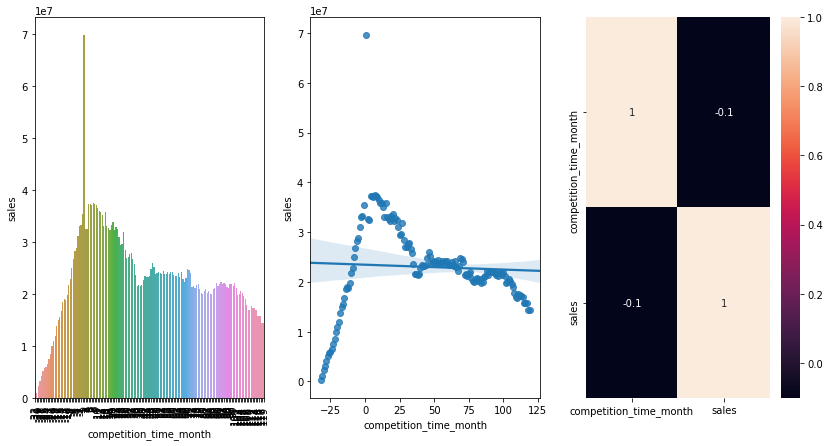

In [45]:
plt.figure(figsize=(14, 7))
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(1, 3, 2)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

***Conclusão:*** lojas com **COMPETIDORES A MAIS TEMPO** vendem **MENOS**.

H3 é hipótese falsa.

#### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais

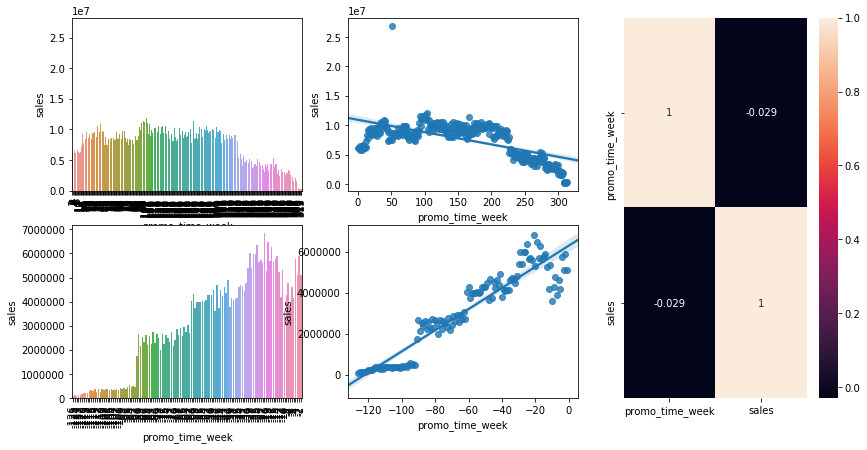

In [46]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

plt.figure(figsize = (14, 7))
grid = gridspec.GridSpec(2, 3)

plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extended
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(grid[0, 1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);

plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks(rotation = 90);

plt.subplot(grid[1, 1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3);

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

***Conclusão:*** lojas com **PROMOÇÃO ATIVAS POR MAIS TEMPO** vendem **MENOS**, depois de um certo período de promoção.

H4 é hipótese falsa.

#### <S>**H5.** Lojas com mais dias de promoção deveriam vender mais<S>

***Conclusão:*** lojas com **MAIS DIAS DE PROMOÇÃO** vendem **MENOS**.

H5 é hipótese falsa.

#### **H6.** Lojas com mais promoções consecutivas deveriam vender mais

In [47]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()


,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


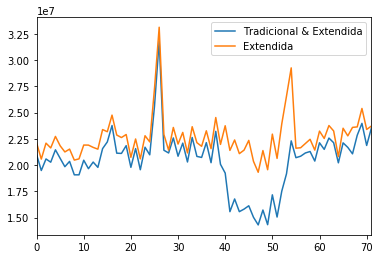

In [48]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] ==1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida']);

***Conclusão:*** lojas com **MAIS PROMOÇÕES CONSECUTIVAS** vendem **MENOS**.

H6 é hipótese falsa.

#### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais

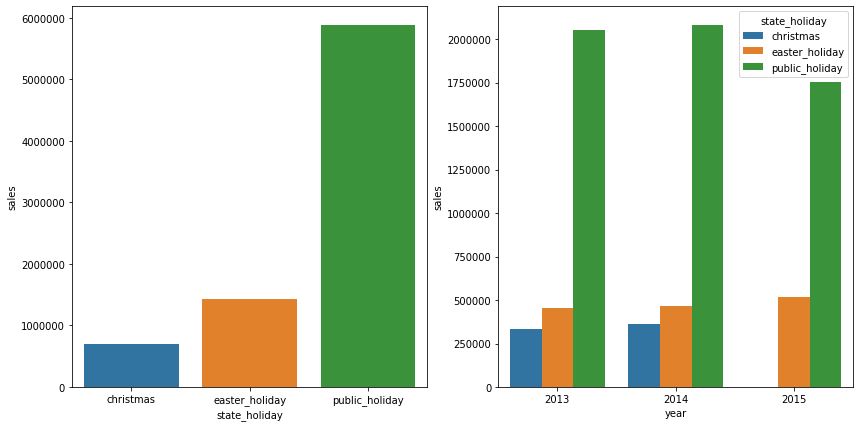

In [49]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.figure(figsize = (14, 7))

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday',  data = aux2);

***Conclusão:*** lojas  **ABERTAS DURANTE O FERIADO DE NATAL** vendem **MENOS**.

H7 é hipótese falsa.

#### **H8.** Lojas deveriam vender mais ao longo dos anos

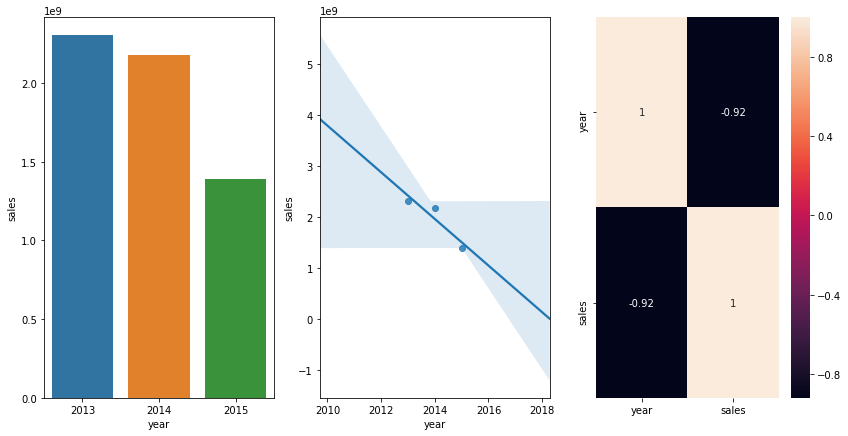

In [50]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
plt.figure(figsize = (14, 7))

plt.subplot(1, 3, 1)
sns.barplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(1, 3, 2)
sns.regplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

***Conclusão:*** lojas **VENDEM MENOS** ao longo dos anos.

H8 é hipótese falsa.

#### **H9.** Lojas deveriam vender mais no segundo semestre do ano

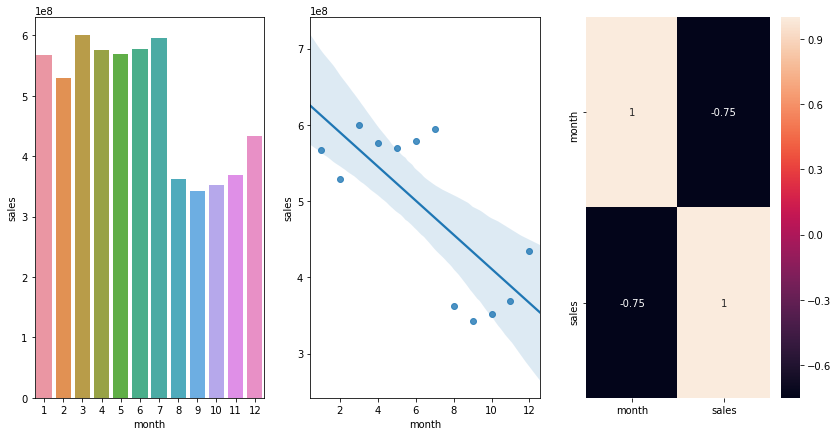

In [51]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
plt.figure(figsize = (14, 7))

plt.subplot(1, 3, 1)
sns.barplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(1, 3, 2)
sns.regplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

***Conclusão:*** lojas **VENDEM MENOS** no segundo semestre do ano.

H9 é hipótese falsa.

#### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês

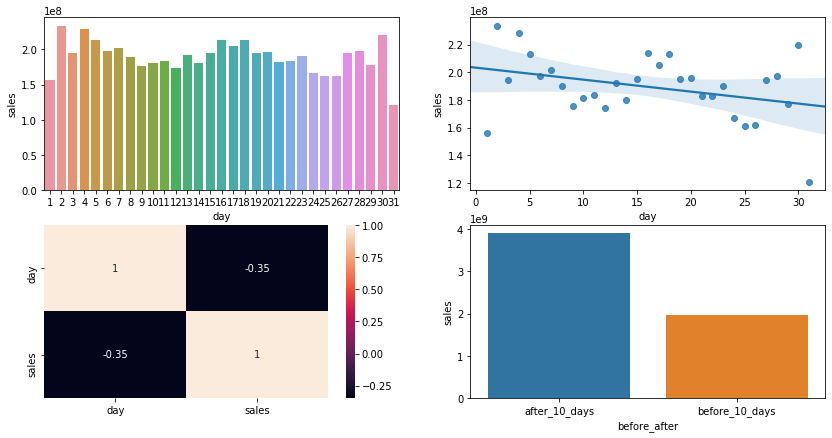

In [52]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
plt.figure(figsize = (14, 7))

plt.subplot(2, 2, 1)
sns.barplot(x = 'day', y = 'sales', data = aux1);

plt.subplot(2, 2, 2)
sns.regplot(x = 'day', y = 'sales', data = aux1);

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

plt.subplot(2, 2, 4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x = 'before_after', y = 'sales', data = aux2); 

***Conclusão:*** lojas **VENDEM MAIS** depois do dia 10 de cada mês.

H10 é hipótese verdadeira.

#### **H11.** Lojas deveriam vender menos aos finais de semana

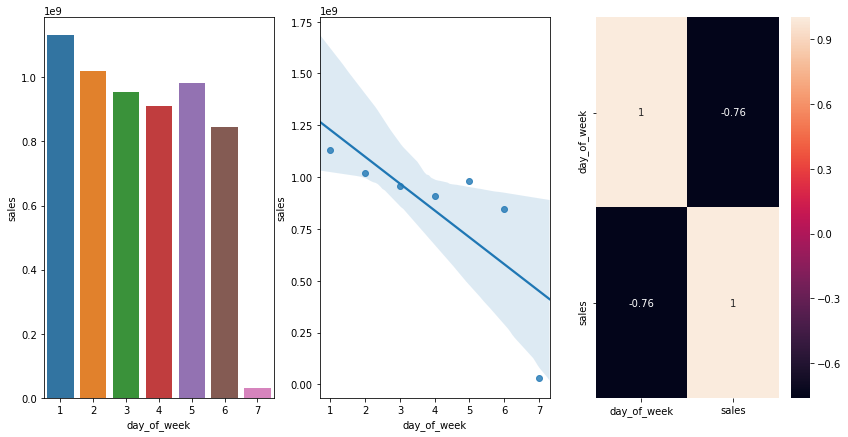

In [53]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
plt.figure(figsize = (14, 7))

plt.subplot(1, 3, 1)
sns.barplot(x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(1, 3, 2)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

***Conclusão:*** lojas **VENDEM MENOS** aos finais de semana.

H11 é hipótese verdadeira.

#### **H12.** Lojas deveriam vender menos durante os feriados escolares

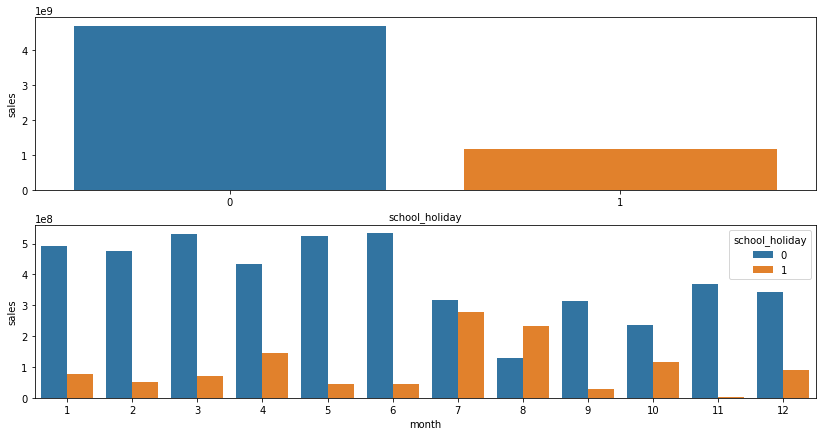

In [54]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.figure(figsize = (14, 7))

plt.subplot(2, 1, 1)
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1);

plt.subplot(2, 1, 2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x = 'month', y = 'sales', hue = 'school_holiday', data = aux2);

***Conclusão:*** lojas **VENDEM MENOS** durante os feriados escolares, exceto nos meses de julho e agosto.

H12 é hipótese verdadeira.

### 4.2.1 Resumo das hipótese

In [55]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'Media'],
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Média'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Baixa'],
     ]
print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Média
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


### 4.3 Análise Multivariada

#### 4.3.1 Numerical Attributes

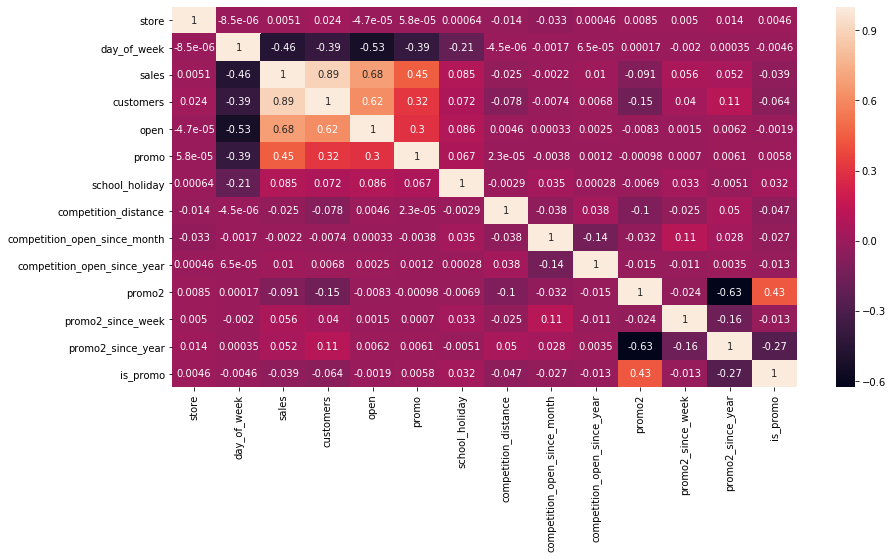

In [56]:
correlation = num_attributes.corr(method = 'pearson')
plt.figure(figsize = (14, 7))
sns.heatmap(correlation, annot = True)

#### 4.3.2 Categorical Attributes

In [57]:
a = df4.select_dtypes(include = 'object')

In [58]:
a1 = cramer_v(a['state_holiday'], a['state_holiday']) 
a2 = cramer_v(a['state_holiday'], a['store_type']) 
a3 = cramer_v(a['state_holiday'], a['assortment']) 

a4 = cramer_v(a['store_type'], a['state_holiday']) 
a5 = cramer_v(a['store_type'], a['store_type']) 
a6 = cramer_v(a['store_type'], a['assortment']) 

a7 = cramer_v(a['assortment'], a['state_holiday']) 
a8 = cramer_v(a['assortment'], a['store_type']) 
a9 = cramer_v(a['assortment'], a['assortment']) 

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]
             })
d = d.set_index(d.columns)
d

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


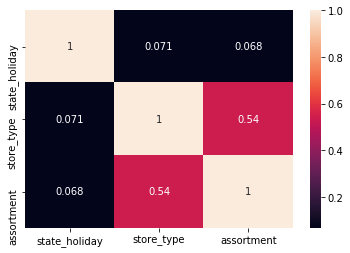

In [59]:
sns.heatmap(d, annot = True)

# 5.0 PREPARAÇÃO DOS DADOS

In [60]:
df5 = df4.copy()

### 5.1 Normalização

##### Não há variáveis com distribuição normal para aplicar normalização.

### 5.2 Rescaling

In [61]:
a = df5.select_dtypes(include = ['int64', 'int32', 'float64', 'UInt32'])

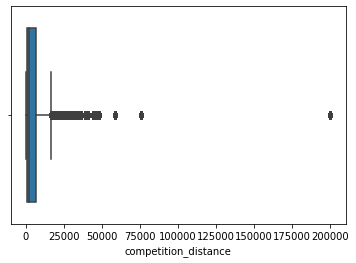

In [62]:
# Verificando se tem outlier para competition_distance
sns.boxplot(x = df5['competition_distance'])

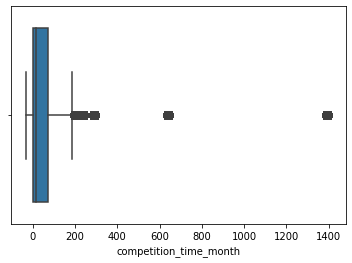

In [63]:
# Verificando se tem outlier para competition_time_month
sns.boxplot(x = df5['competition_time_month'])

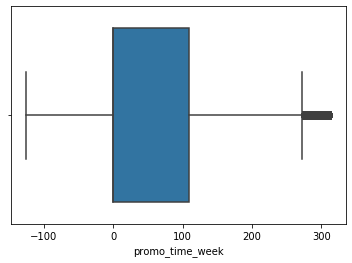

In [64]:
# Verificando se tem outlier para promo_time_week
sns.boxplot(x = df5['promo_time_week'])

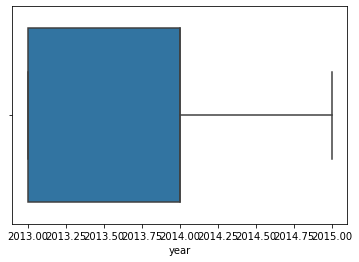

In [65]:
# Verificando se tem outlier para year
sns.boxplot(x = df5['year'])

In [67]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('/home/marcela-pretto-amorim/ds/repos/curso-ds-producao/parameter/competition_distance_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('/home/marcela-pretto-amorim/ds/repos/curso-ds-producao/parameter/competition_time_month_scaler.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open('/home/marcela-pretto-amorim/ds/repos/curso-ds-producao/parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('/home/marcela-pretto-amorim/ds/repos/curso-ds-producao/parameter/year_scaler.pkl', 'wb'))


### 5.3 Transformação

#### 5.3.1 Encoding

In [68]:
# state_holiday
# Método get_dummies usado para realizar codificação one-hot encoding
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

# store_type
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('/home/marcela-pretto-amorim/ds/repos/curso-ds-producao/parameter/store_type_scaler.pkl', 'wb'))

# assortment
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

#### 5.3.2 Response Variable Transformation

In [69]:
df5['sales'] = np.log1p(df5['sales'])

#### 5.3.3 Nature Transformation

In [70]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))

# 6.0 FEATURE SELECTION

In [71]:
df6 = df5.copy()

### 6.1 Split dataframe into training and test dataset

In [72]:
# Eliminacao de colunas 
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis =1)

In [73]:
 df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [74]:
# Training dataset
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

# Test dataset
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

print('Training Min Date {}'.format(x_train['date'].min()))
print('Training Max Date {}'.format(x_train['date'].max()))
      
print('Test Min Date {}'.format(x_test['date'].min()))
print('Test Max Date {}'.format(x_test['date'].max()))

Training Min Date 2013-01-01 00:00:00
Training Max Date 2015-06-18 00:00:00
Test Min Date 2015-06-19 00:00:00
Test Max Date 2015-07-31 00:00:00


### 6.2 Boruta as Feature Selector

In [75]:
# training and test dataset for Boruta
#x_train_n = x_train.drop(['date', 'sales'], axis = 1).values
#y_train_n = y_train.values.ravel()

# Define Random Forest Regressor
#rf = RandomForestRegressor(n_jobs = -1)

# Define Boruta
#boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(x_train_n, y_train_n)

#### 6.2.1 Best features from Boruta

In [76]:
#cols_selected = boruta.support_.tolist()

## best features
#x_train_fs = x_train.drop(['date', 'sales'], axis = 1)
#cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

#cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

### 6.3 Manual feature selection

In [77]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 MACHINE LEARNING MODELING

In [78]:
x_train_model = x_train[cols_selected_boruta]
x_test_model = x_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = x_train[cols_selected_boruta_full]

### 7.1 Average Model

In [79]:
aux1 = x_test_model.copy()
aux1['sales'] = y_test.copy()

# Prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how = 'left', on = 'store')
yhat_baseline = aux1['predictions']

# Performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


### 7.2 Linear Regression Model

In [80]:
# Model
lr = LinearRegression().fit(x_train_model, y_train)

# Prediction
yhat_lr = lr.predict(x_test_model)

# Performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


#### 7.2.1 Linear Regression Model - Cross Validation

In [81]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose = False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


### 7.3 Linear Regression Regularized Model - Lasso

In [82]:
# Model
lrr = Lasso(alpha = 0.01).fit(x_train_model, y_train)

# Prediction
yhat_lrr = lrr.predict(x_test_model)

# Performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


#### 7.3.1 Lasso - Cross Validation

In [83]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose = False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


### 7.4 Random Forest Regressor

In [84]:
# Model
rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 42).fit(x_train_model, y_train)

# Prediction
yhat_rf = rf.predict(x_test_model)

# Performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

: 

#### 7.4.1 Random Forest Regressor - Cross Validation

In [ ]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose = False)
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17


### 7.5 XGBoost Regressor

In [ ]:
# Model
model_xgb = xgb.XGBRegressor().fit(x_train_model, y_train)

# Prediction
yhat_xgb = model_xgb.predict(x_test_model)

# Performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,868.958205,0.130309,1238.550843


#### 7.5.1 XGBoost Regressor - Cross Validation

In [ ]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost', model_xgb, verbose = False)
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,1064.94 +/- 178.65,0.15 +/- 0.02,1519.92 +/- 242.12


### 7.6 Compare Models Performance

#### 7.6.1 Single Performance

In [ ]:
modeling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modeling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,XGBoost Regressor,868.958205,0.130309,1238.550843
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


#### 7.6.2 Real Performance - Cross Validation

In [ ]:
modeling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
#modeling_result_cv.sort_values('RMSE CV')
modeling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17
0,XGBoost,1064.94 +/- 178.65,0.15 +/- 0.02,1519.92 +/- 242.12


# 8.0 HYPERPARAMETER FINE TUNING

### 8.1 Random Search

In [ ]:
#param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }
## Nº de iterações
#MAX_EVAL = 5

In [ ]:
#final_result = pd.DataFrame()
#
#for i in range(MAX_EVAL):
#    # Choose values for parameters randomly
#    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#    print(hp)
#    
#    # Model
#    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
#                                 n_estimators = hp['n_estimators'],
#                                 eta = hp['eta'],
#                                 max_depth = hp['max_depth'],
#                                 subsample = hp['subsample'],
#                                 colsample_bytree = hp['colsample_bytree'],
#                                 min_child_weight = hp['min_child_weight'])
#    # Performance
#    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose = True)
#    final_result = pd.concat([final_result, result])
#    
#final_result  

### 8.2 Final Model

In [ ]:
param_tuned = {
                'n_estimators': 3000,
                'eta': 0.03,
                'max_depth': 5,
                'subsample': 0.7,
                'colsample_bytree': 0.7,
                'min_child_weight': 3
                }

In [ ]:
# Model
model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
                                   n_estimators = param_tuned['n_estimators'],
                                   eta = param_tuned['eta'],
                                   max_depth = param_tuned['max_depth'],
                                   subsample = param_tuned['subsample'],
                                   colsample_bytree = param_tuned['colsample_bytree'],
                                   min_child_weight = param_tuned['min_child_weight']).fit(x_train_model, y_train)

# Prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test_model)

# Performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,770.209978,0.115623,1108.062869


In [ ]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

-0.01598888634252212

# 9.0 TRADUCAO E INTERPRETACAO DO ERRO

In [ ]:
df9 = x_test.loc[:, cols_selected_boruta_full]

# Rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

### 9.1 Business Performance

In [ ]:
# Sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: 'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how = 'inner', on = 'store')
df92 = pd.merge(df91, df9_aux3, how = 'inner', on = 'store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [ ]:
df92.sort_values('MAPE', ascending = False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,107259.992188,103900.995760,110618.988615,3358.996428,0.588526
908,909,218136.984375,210139.046769,226134.921981,7997.937606,0.523377
169,170,210068.781250,208498.057327,211639.505173,1570.723923,0.388486
901,902,202738.703125,201256.792243,204220.614007,1481.910882,0.369999
875,876,196581.156250,192483.555006,200678.757494,4097.601244,0.338941


<AxesSubplot:xlabel='store', ylabel='MAPE'>

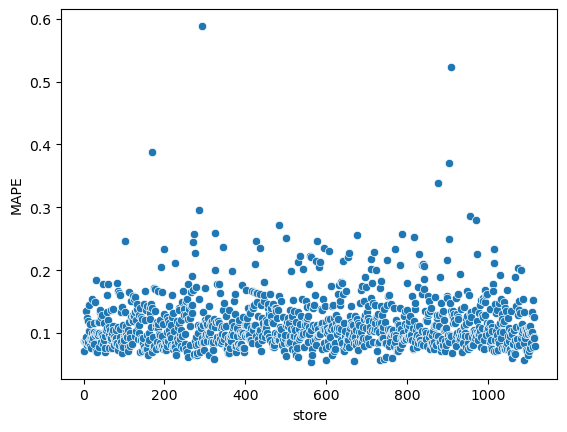

In [ ]:
sns.scatterplot(x = 'store', y = 'MAPE', data = df92)

### 9.2 Total Performance

In [ ]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns = {'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$285,817,920.00"
1,worst_scenario,"R$284,955,855.77"
2,best_scenario,"R$286,679,971.85"


### 9.3 Machine Learning Performance

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Usuario\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='predictions', ylabel='error'>

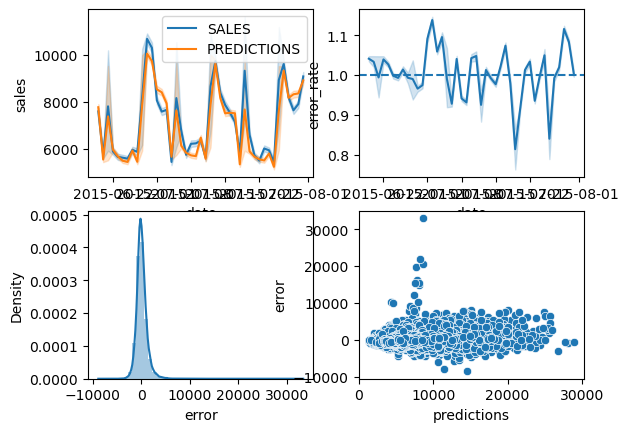

In [ ]:
plt.subplot(2, 2, 1)
sns.lineplot(x = 'date', y = 'sales', data = df9, label = 'SALES')
sns.lineplot(x = 'date', y = 'predictions', data = df9, label = 'PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x = 'date', y = 'error_rate', data = df9)
plt.axhline(1, linestyle = '--')

plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

# Grafico de residuo
plt.subplot(2, 2, 4)
sns.scatterplot(df9['predictions'], df9['error'])

# 10.0 DEPLOY MODEL TO PRODUCTION

In [ ]:
# Save trained model
pickle.dump(model_xgb_tuned, open('C:/Users/Usuario/Documents/ds/repos/curso-producao-ds/model/model_rossmann.pkl', 'wb'))

### 10.1 Rossmann Class

In [ ]:
import math
import pickle
import datetime
import inflection
import numpy  as np
import pandas as pd

In [ ]:
import math
import pickle
import datetime
import inflection
import numpy  as np
import pandas as pd 

class Rossmann(object):
    def __init__(self):
        self.home_path = 'C:/Users/Usuario/Documents/ds/repos/curso-producao-ds/'
        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
        
    def data_cleaning(self, df1):
       # 1.1 Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 'SchoolHoliday',
            'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x) 
    
        cols_new = list(map(snakecase, cols_old)) 

        # Rename
        df1.columns = cols_new
        
        # 1.3 Data types
        df1['date'] = pd.to_datetime(df1['date'])
        
        # 1.5 Fillout NA
        # competition_distance = distancia entre a loja e uma concorrente  
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )
        
        # competition_open_since_month = mes em que o competidor mais proximo foi aberto   
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)
        
        # competition_open_since_year = ano em que o competidor mais proximo foi aberto   
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)
        
        # promo2_since_week = se a loja esta com programa de promocao continuada; 0 não está com promocao e 1 indica que está              
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)
        
        # promo2_since_year = se a loja esta com programa de promocao continuada; 0 não está com promocao e 1 indica que está       
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)
        
        # promo_interval = quando começou a promocao   
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        
        df1['promo_interval'].fillna(0, inplace = True)
        
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis = 1)
        
        # 1.6 Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
        
        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
        df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
        
        return df1
    
    def feature_engineering(self, df2):
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')
        
        # 3.1 Filtragem das linhas
        df2 = df2[df2['open'] != 0]
        
        # 3.2 Seleção das colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis =1)
        
        return df2
    
    def data_preparation(self, df5):
        # 5.2 Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_distance']].values)

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['competition_distance']].values)

        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['competition_distance']].values)
        
        # 5.3.1 Encoding
        # state_holiday - One Hot Enconding
        # Método get_dummies usado para realizar codificação one-hot encoding
        df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])
        
        # store_type - Label Enconding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])
                
        # assortment - Ordinal Enconding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)
        
        # 5.3.3 Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))
        
        cols_selected = ['store', 'promo','store_type','assortment','competition_distance','competition_open_since_month','competition_open_since_year',
                                'promo2','promo2_since_week','promo2_since_year','competition_time_month','promo_time_week','day_of_week_sin','day_of_week_cos',
                                'month_sin','month_cos','day_sin','day_cos','week_of_year_sin','week_of_year_cos']
        
        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)
        
        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient = 'records', date_format = 'iso')
        

### 10.2 API Handler

In [ ]:
import pickle
import pandas as pd

from rossmann.Rossmann import Rossmann
from flask import Flask, request, Response

# loading model
model = pickle.load(open('C:/Users/Usuario/Documents/ds/repos/curso-producao-ds/model/model_rossmann.pkl', 'rb'))

# initialize API
app = Flask( __name__ )
@app.route('/rossmann/predict', methods=['POST'])

def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance(test_json, dict): # Unique example
            test_raw = pd.DataFrame(test_json, index = [0])
        else: # Multiple examples
            test_raw = pd.DataFrame(test_json, columns = test_json[0].keys())
        
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # Data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # Feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # Data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
    else:
        return Responde('{}', status = 200, mimetype = 'application/json')

if __name__ == '__main__':
    app.run('localhost') # parâmetro localhost indica que irá rodar na máquina local

ModuleNotFoundError: No module named 'rossmann'

### 10.3 API Tester

In [ ]:
# loading test dataset
df10 = pd.read_csv( 'C:/Users/Usuario/Documents/ds/repos/curso-producao-ds/test.csv' )

In [ ]:
import json
import requests

# Merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how = 'left', on = 'Store')

# Choose store for prediction
df_test = df_test[df_test['Store'] == 22]

# Remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[-df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis = 1)

In [ ]:
# Convert Dataframe to json
data = json.dumps(df_test.to_dict(orient = 'records'))

In [ ]:
# API Call
url = 'http://localhost:5000/rossmann_predict' # porta 5000 é a porta padrão do Flask
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data, headers = header)
print('Status Code {}'.format(r.status_code))

In [ ]:
df_test.head()